In [0]:
from pyspark.sql import Row
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
from pyspark.sql import functions as F 
from pyspark.sql.functions import explode, col, udf, mean as _mean, stddev as _stddev, log, log10
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.functions import lit


from pyspark.sql.functions import udf, expr, concat, col, count, when, isnan

spark = SparkSession(sc)
sqlc=SQLContext(sc)

In [0]:
train_features = sqlc.read.csv('/FileStore/tables/train_features.csv', header = True,inferSchema=True)
test_features = sqlc.read.csv('/FileStore/tables/test_features.csv', header = True,inferSchema=True)
train_targets_scored = sqlc.read.csv('/FileStore/tables/train_targets_scored.csv', header = True,inferSchema=True)

In [0]:
value = []
for i in train_targets_scored.schema.names:
  v = train_targets_scored.select(i).where(train_targets_scored[i] == '1').count()
  value.append(v)

In [0]:
from pyspark.sql.types import IntegerType
from pyspark.sql import *
from pyspark.sql.functions import *
DF = spark.createDataFrame(value,IntegerType())
l = train_targets_scored.schema.names
t = sqlContext.createDataFrame([(i,) for i in l], ['targets'])
w=Window.orderBy(lit(1))
df4=DF.withColumn("rn",row_number().over(w)-1)
df3=t.withColumn("rn",row_number().over(w)-1)
df4 = df3.join(df4,["rn"]).drop("rn")
df4.show()

+--------------------+-----+
 targets|value|
+--------------------+-----+
 sig_id| 0|
5-alpha_reductase...| 17|
11-beta-hsd1_inhi...| 18|
 acat_inhibitor| 24|
acetylcholine_rec...| 190|
acetylcholine_rec...| 301|
acetylcholinester...| 73|
adenosine_recepto...| 54|
adenosine_recepto...| 96|
adenylyl_cyclase_...| 12|
adrenergic_recept...| 270|
adrenergic_recept...| 360|
 akt_inhibitor| 66|
aldehyde_dehydrog...| 7|
 alk_inhibitor| 42|
 ampk_activator| 12|
 analgesic| 12|
androgen_receptor...| 48|
androgen_receptor...| 89|
 anesthetic_-_local| 80|
+--------------------+-----+
only showing top 20 rows

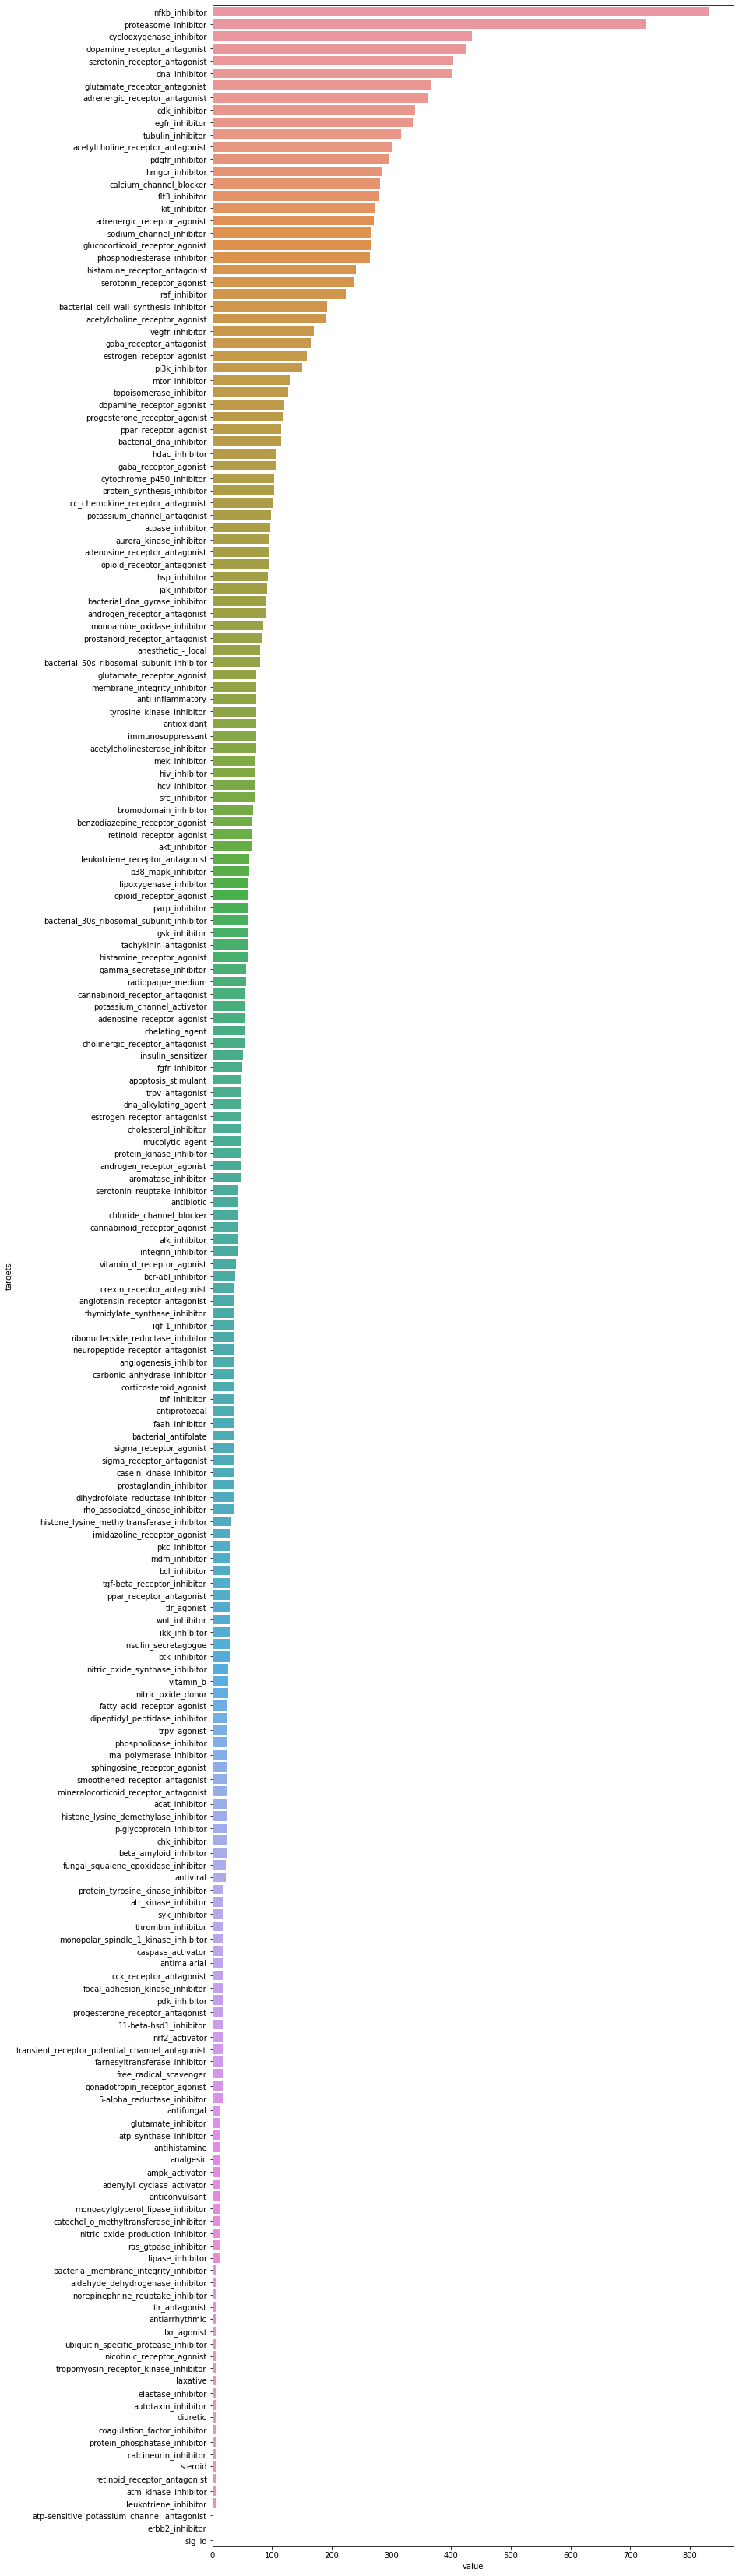

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df_target =  df4.select("*").toPandas()
df_target = df_target.sort_values(by = ['value'], ascending=False)
fig = plt.figure(figsize=(12, 60))
sns.barplot(x=df_target.value, y=df_target.targets)

In [0]:
# target types
target_type = ['inhibitor', 'antagonist', 'agonist', 'activator', 'agent', 'stimulant', 'blocker', 'diuretic', 'donor', 'steroid', 'laxative', 'medium', 'anti', 'scavenger', 'local', 'secretagogue', 'vitamin', 'analgesic', 'immu']
type_tar = []
type_sum = []
for i in target_type:
  typ = df4.filter(df4.targets.contains(i))
  type_tar.append(typ)
  sum_typ = typ.groupBy().sum().collect()[0][0]
  type_sum.append(sum_typ)           

In [0]:
df_type = spark.createDataFrame(type_sum,IntegerType())
df_tar = sqlContext.createDataFrame([(i,) for i in target_type], ['target_type'])
w = Window.orderBy(lit(1))
df6 = df_type.withColumn("rn",row_number().over(w)-1)
df5 = df_tar.withColumn("rn",row_number().over(w)-1)
df6 = df5.join(df6,["rn"]).drop("rn")
df6.sort(col('value'), ascending=False).show()

+------------+-----+
 target_type|value|
+------------+-----+
 inhibitor| 9693|
 agonist| 5779|
 antagonist| 3449|
 anti| 345|
 blocker| 323|
 agent| 150|
 activator| 115|
 local| 80|
 immu| 73|
 vitamin| 65|
 medium| 56|
 stimulant| 49|
 steroid| 42|
secretagogue| 30|
 donor| 26|
 scavenger| 18|
 analgesic| 12|
 diuretic| 6|
 laxative| 6|
+------------+-----+

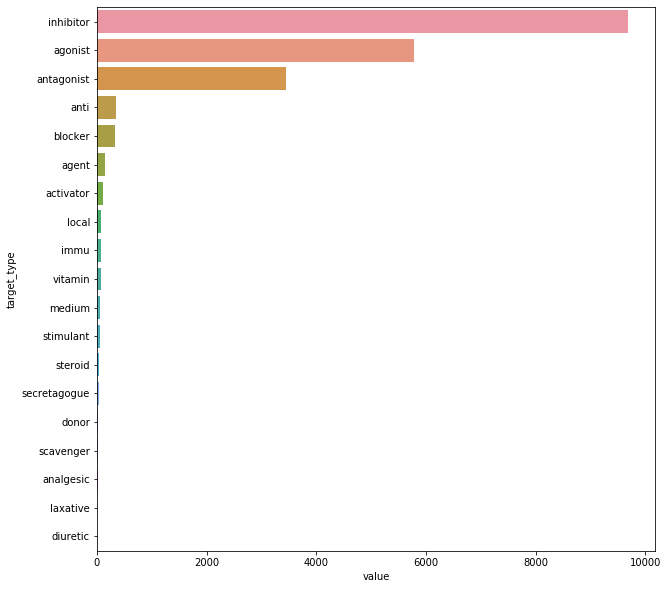

In [0]:
df_target_type =  df6.select("*").toPandas()
df_target_type = df_target_type.sort_values(by = ['value'], ascending=False)
fig = plt.figure(figsize=(10, 10))
sns.barplot(x=df_target_type.value, y=df_target_type.target_type)

In [0]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import StringIndexer
df_train = train_features.join(train_targets_scored.select(l[1]))
df_train = df_train.drop('cp_type')
df_train_clean = StringIndexer().setInputCol("cp_dose").setOutputCol("cp_dose_enco").fit(df_train).transform(df_train)
df_train_clean = StringIndexer().setInputCol("cp_time").setOutputCol("cp_time_enco").fit(df_train).transform(df_train_clean)

In [0]:
from pyspark.ml.stat import Correlation
df_train_clean = df_train_clean.drop('cp_dose')
df_train_clean = df_train_clean.drop('cp_time')
df_train_clean = df_train_clean.drop('sig_id')
df_target = train_targets_scored.drop('sig_id')

def corr (df):
  ass = VectorAssembler(inputCols=[x for x in df.schema.names], outputCol="targets")
  corr_input = ass.transform(df).select("targets")
  r_target = Correlation.corr(corr_input, "targets").collect()[0][0]
  corrmatrix = r_target.toArray().tolist()
  corr_tar = spark.createDataFrame(corrmatrix,df.schema.names)
  pd_df_corr =  corr_tar.select("*").toPandas()
  return corrmatrix, pd_df_corr

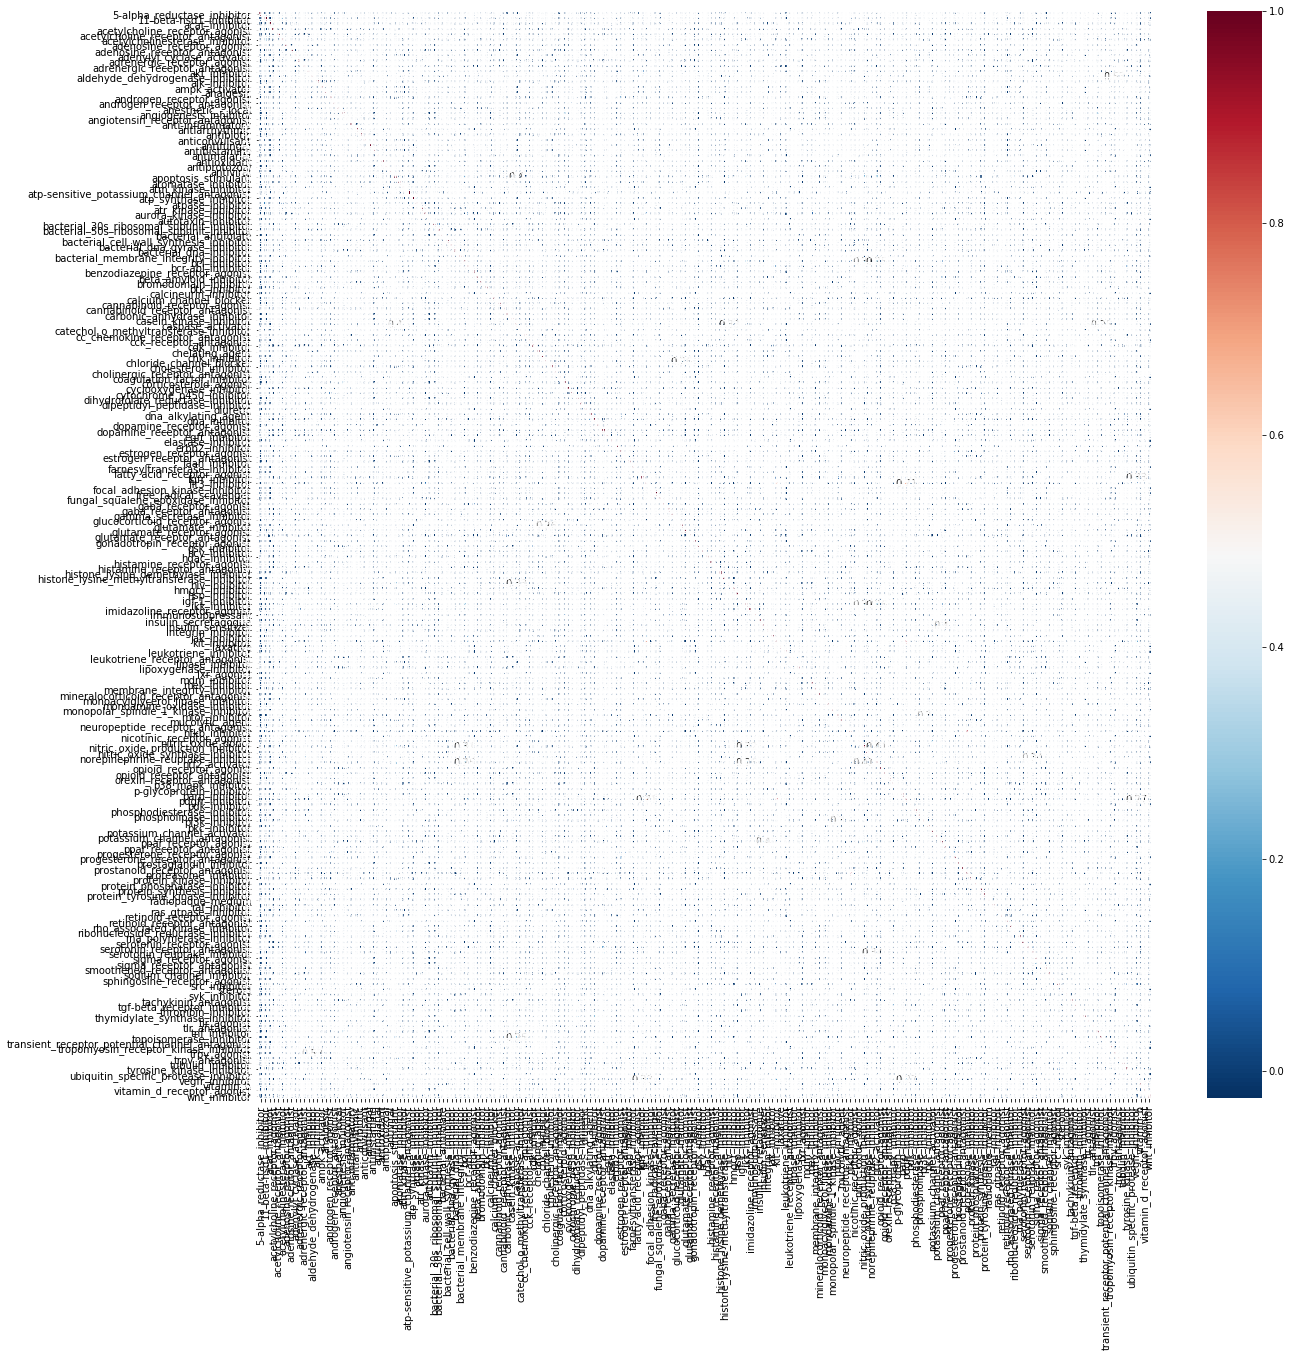

In [0]:
# all targets
plt.subplots(figsize=(20,20))
sns.heatmap(df_corr, 
           xticklabels=df_corr.columns,
           yticklabels=df_corr.columns,cmap='RdBu_r',
           annot=True,
           linewidth=0.5)

In [0]:
l1 = [ row.targets for row in type_tar[0].select('targets').collect()]
ass = VectorAssembler(inputCols=[x for x in df_target.schema.names if x in l1], outputCol="targets")
corr_input = ass.transform(df_target).select("targets")
r_target = Correlation.corr(corr_input, "targets").collect()[0][0]
corrmatrix = r_target.toArray().tolist()
corr_tar = spark.createDataFrame(corrmatrix,l1)
pd_df_corr =  corr_tar.select("*").toPandas()

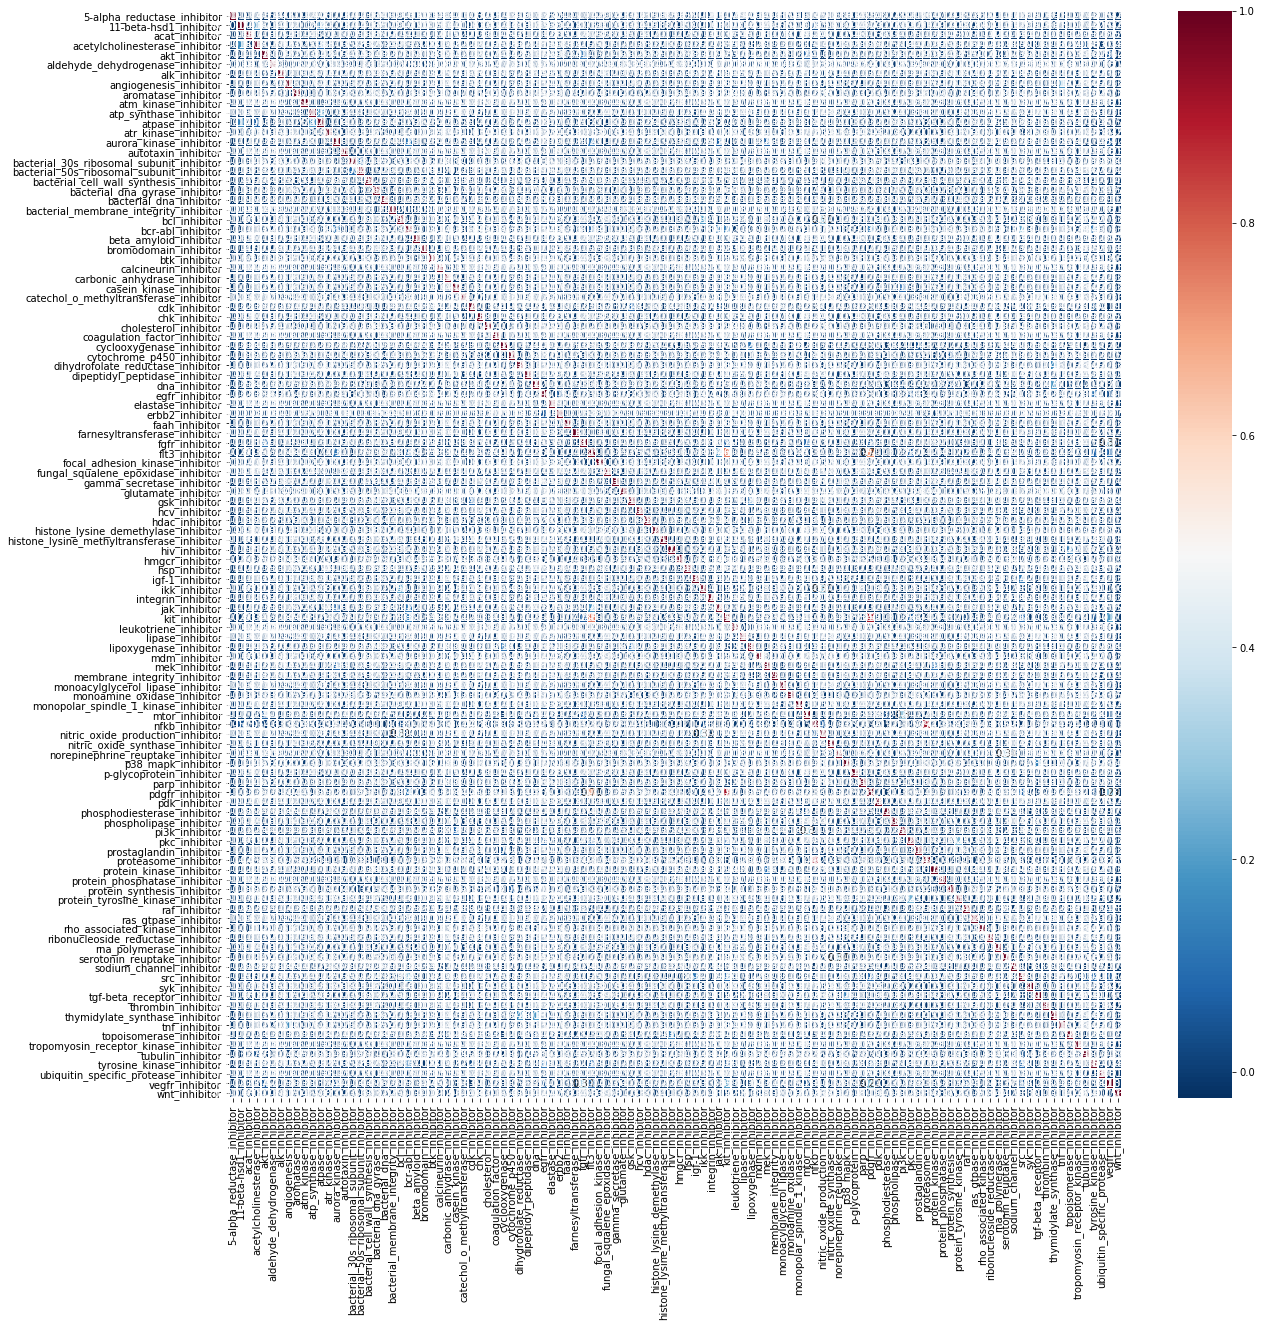

In [0]:
# target inhibitor
plt.subplots(figsize=(20,20))
sns.heatmap(pd_df_corr, 
           xticklabels=pd_df_corr.columns,
           yticklabels=pd_df_corr.columns,cmap='RdBu_r',
           annot=True,
           linewidth=0.5)

In [0]:
# NaiveBayes model
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import StringIndexer

train, test = df_train_clean.randomSplit([0.7, 0.3],1234)
assembler = VectorAssembler(inputCols=[x for x in df_train_clean.schema.names], outputCol="features")
train_df = (assembler.transform(train).select('5-alpha_reductase_inhibitor', "features"))
test_df = (assembler.transform(test).select('5-alpha_reductase_inhibitor', "features"))
nb = NaiveBayes(labelCol='5-alpha_reductase_inhibitor', featuresCol="features",smoothing=1.0, modelType="multinomial")
model = nb.fit(train_df)
predictions = model.transform(test_df)
display(predictions.select("label", "prediction", "probability"))

In [0]:
g_list = [i for i in train_features.schema.names if i.startswith('g-')]
c_list = [i for i in train_features.schema.names if i.startswith('c-')]

def corr (feature, set_max, set_min):
  
  ass = VectorAssembler(inputCols=[x for x in train_features.schema.names if x in feature], outputCol="features")
  corr_input = ass.transform(train_features).select("features")
  r_target = Correlation.corr(corr_input, "features").collect()[0][0]
  corrmatrix = r_target.toArray().tolist()
  corr_tar = spark.createDataFrame(corrmatrix,feature)
  pd_df_corr = corr_tar.select("*").toPandas()
  pd_corr = pd_df_corr.abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
  pd_corr = pd_corr[pd_corr['level_0'] != pd_corr['level_1']] #preventing 1.0 corr
  
  corr_max = pd_corr.level_0.head(set_max).tolist()
  corr_max = list(set(corr_max))
  
  corr_min = pd_corr.level_0.tail(set_min).tolist()
  corr_min = list(set(corr_min))
  
  correlation_train_max = pd_df_corr.loc[:,corr_max].corr()
  mask_max = np.triu(correlation_train_max.corr())
  
  correlation_train_min = pd_df_corr.loc[:,corr_min].corr()
  mask_min = np.triu(correlation_train_min.corr())
  
  return correlation_train_max, correlation_train_min, mask_max, mask_min

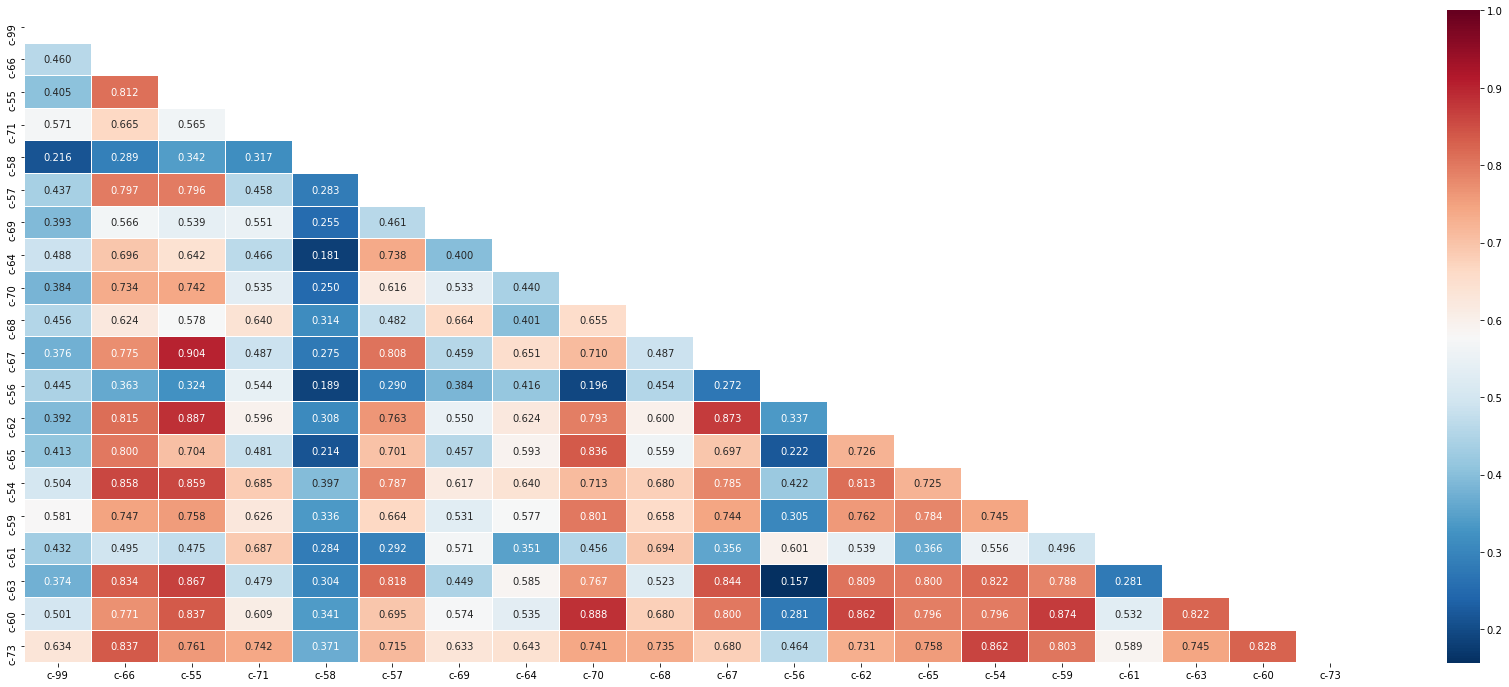

In [0]:
c_correlation_train_max, c_correlation_train_min, c_mask_max, c_mask_min = corr (c_list, 20, 20)
plt.figure(figsize=(30, 12))
sns.heatmap(c_correlation_train_max,
            mask=c_mask_max,
            annot=True,
            fmt='.3f',
            cmap='RdBu_r',
            linewidths=0.01,
            cbar=True)

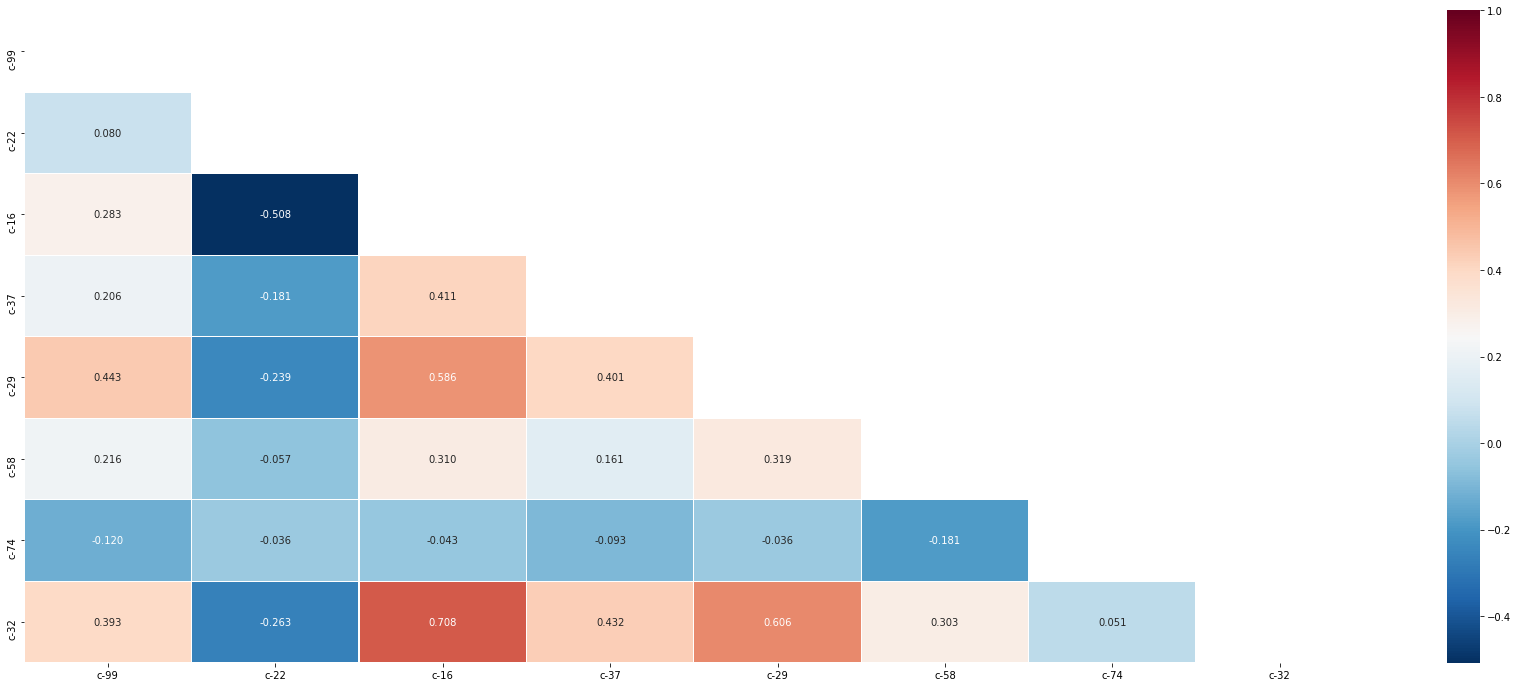

In [0]:
plt.figure(figsize=(30, 12))
sns.heatmap(c_correlation_train_min,
            mask=c_mask_min,
            annot=True,
            fmt='.3f',
            cmap='RdBu_r',
            linewidths=0.01,
            cbar=True)

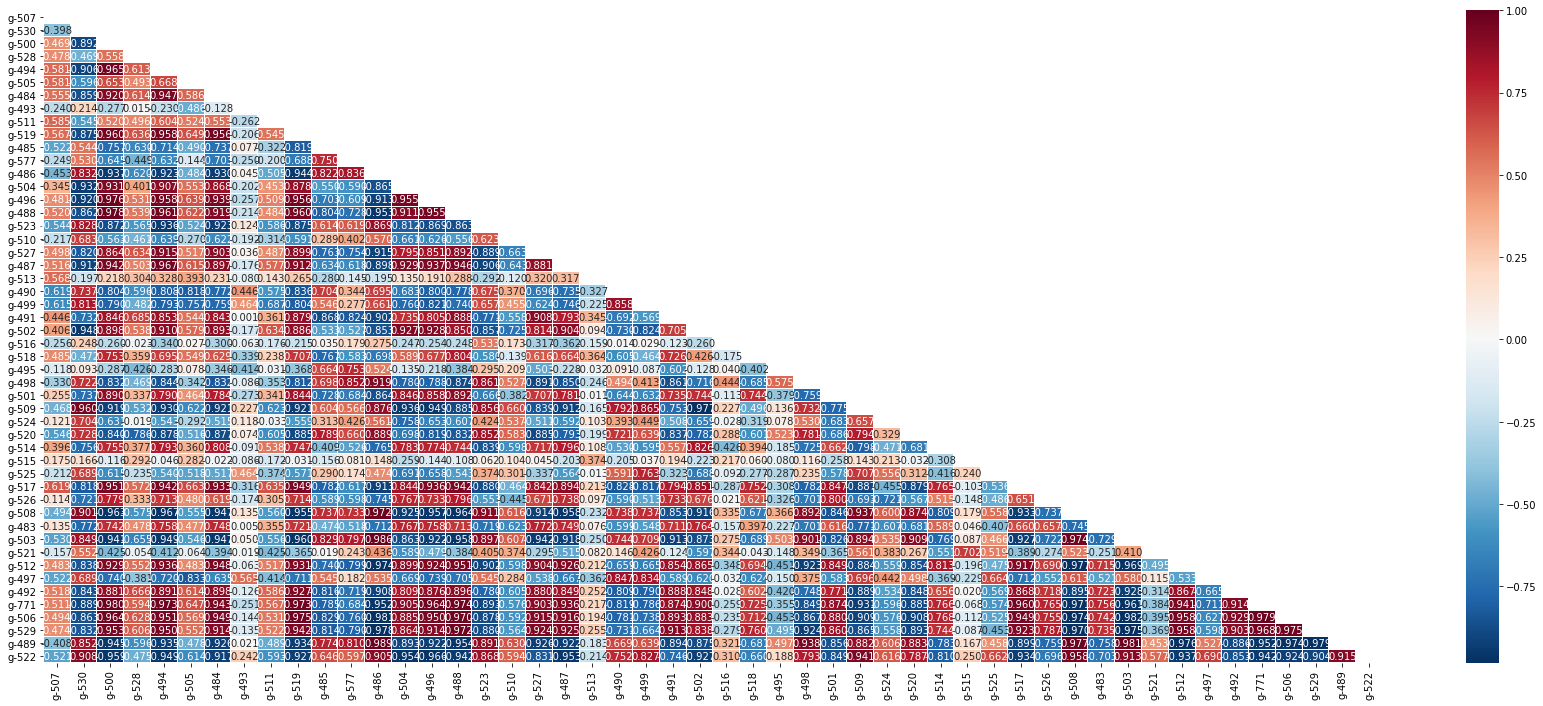

In [0]:
g_correlation_train_max, g_correlation_train_min, g_mask_max, g_mask_min = corr (g_list, 50, 50)
plt.figure(figsize=(30, 12))
sns.heatmap(g_correlation_train_max,
            mask=g_mask_max,
            annot=True,
            fmt='.3f',
            cmap='RdBu_r',
            linewidths=0.01,
            cbar=True)

In [0]:
def mean_columnwise_logloss(y_true, y_pred):        
  y_pred = np.clip(y_pred, 1e-15, (1 - 1e-15))
  score = - np.mean(np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred), axis=1))
  return score